# Performing NCGR on a full forecast field

This notebook walks you through how to use the `NCGR` package to perform non-homogenous Gaussian regression (NCGR) on a full field of ice-free date or freeze-up date forecasts using the `NCGR.ncgr_fullfield` module. For this specific example, we'll be calibrating a freeze-up date forecast. This option is **plug-and-play**, and allows the user to provide a forecast, training hindcasts, and training observations in NetCDF files. An output netCDF file is produced that contains a calibrated probabilistic ice-free date/freeze-up date forecast.

Outline
-----------
* The first section of this notebook, **Working Script**, offers a copy and pasteable section of code that performs NCGR on a forecast ice-free date or freeze-up date field.

* The second section section of the notebook, **Detailed explanation**, goes through step-by-step and provides insights on each piece of code. 

* The third section of the notebook, **Plotting**, shows how to load the output NetCDF file created in the previous section (it's pre-made so you don't have to run the previous section), and create a figure showing a three-category forecast for early, near-normal, and late ice-free date/freeze-up date forecast.

*Hint: You can hold "shift+tab" inside the parenthesis of any function in the notebook to see its help/docstring.*

## Working Script

```python
from NCGR import ncgr, sitdates

# input filenames
hc_netcdf = './Data/fud_hc_1981_2019_im10.nc' 
obs_netcdf = './Data/fud_obs_1981_2019_im10.nc' 
fcst_netcdf = './Data/fud_fcst_2020_im10.nc' 
clim_netcdf = './Data/fud_clim_2011_2019_im10.nc'   

# output filename (this usually doesn't exist yet)
out_netcdf = './Data/fud_fcst_ncgr_2020_im10.nc'

# Dictionary defining the relevant variables/dimensions for hc_netcdf and fcst_netcdf
model_dict = ({'event_vn' : 'fud', # variable name for the ice-free date or freeze-up date variable
                   'time_vn' : 'time'}, # variable name for the time coordinate
                  {'time_dn' : 'time', # dimension name for the time coordinate
                   'ens_dn' : 'ensemble'}) # dimension name for the forecast realization coordinate

# Dictionary defining the relevant variables/dimensions for obs_netcdf
obs_dict = ({'event_vn' : 'fud',  # variable name for the ice-free date or freeze-up date variable
                 'time_vn' : 'time'}, # variable name for the time coordinate
                {'time_dn' : 'time'}) # dimension name for the time coordinate

im = 10 # initialization month
si_time = sitdates(event='fud')
a = si_time.get_min(im)
b = si_time.get_max(im)

# calibrate 
ncgr.ncgr_fullfield(fcst_netcdf, hc_netcdf, obs_netcdf, out_netcdf,
                  a, b, model_dict, obs_dict, 
                  clim_netcdf=clim_netcdf) 
```

## Detailed explanation

Import necessary modules and create a variable for the event of interest (can be either `event='fud'` or `event='ifd'`):

In [1]:
import ncgr
from sitdates import sitdates
from netCDF4 import Dataset
import netCDF4 as nc4

event = 'fud' 

We'll now define a string-type variable for each of the NetCDF files (path+filename) to be used as inputs to ``ncgr.ncgr_fullfield()``. Details on these files are given below. 

In [2]:
fcst_netcdf = './Data/fud_fcst_2020_im10.nc' # forecast to calibrate
hc_netcdf = './Data/fud_hc_1981_2019_im10.nc' # training forecasts/hindcasts
obs_netcdf = './Data/fud_obs_1981_2019_im10.nc' # training observations
clim_netcdf = './Data/fud_clim_2011_2019_im10.nc' # observations for definining climatology

### Details of input NetCDF files

* All of the files must have the same spatial coordinates. 
* The time-like variable in each file must be CF compliant.
* The files contain ice-free dates or freeze-up dates, not daily ice concentration values. Thus, it is up to the user to compute those dates and create these files before using `NCGR`.

#### fcst_netcdf 
* Must contain a variable with the name 'ifd' or 'fud', containing the ice-free date (if 'ifd') or freeze-up date (if 'fud') forecast to be calibrated. The values should be in day-of-year format (e.g. 1=Jan. 1, 273=Sep. 31, 365=Dec. 31).
* Dimensions of the {'ifd','fud'} variable must be (in plain language): `(time, ensemble, latitude, longitude)` 
    * The actual dimension/variable names can be anything, and will be specified shortly using the `model_dict` variable. 
    * The shape of the time dimension should be 1, and the corresponding variable should contain the start date of the forecast.
* Masked values are ignored in the input files and the output file created will contain masked value s in the same locations.

#### hc_netcdf 
* Same as `fcst_netcdf`, except that the shape of the time variable should be :math:`N`, corresponding to the number of years in the hindcast record. The corresponding variable should contain the start dates of all the hindcasts used for training.

#### obs_netcdf
* Same as `hc_netcdf`, except that the dimensions of the {'ifd','fud'} variable must be (in plain language): `(time, latitude, longitude)` (i.e. the observed dates do not have an ensemble-like coordinate).

#### clim_netcdf
* Same as `obs_netcdf`, except that this file contains the observed ice-free or freeze-up dates to be used to define the climatology relative to which forecast probabilities are computed. For this example, `clim_netcdf` was created directly from `obs_netcdf` by selecting the last 10 years of observations to be used for the climatology with CDO: 
```
cdo seltimeyear,2011/2019/1 obs_netcdf clim_netcdf
```

Next, we'll define a string-type variable for the output NetCDF file (path+filename) to be created:

In [3]:
# output filename (this usually doesn't exist yet; if it does, it will be overwritten)
out_netcdf = './Data/fud_fcst_ncgr_2020_im10.nc'

Two dictionaries need to be created that define the relevant variable names and dimension names in the input NetCDF files. First, create a dictionary representing the relevant terms in the `fcst_netcdf` and `hc_netcdf` files. In practice, for your own NetCDF files, you would want to replace the entries to the right of each ":" with those in your NetCDF files. 

In [4]:
model_dict = ({'event_vn' : event, # variable name of the ice-free date or freeze-up date variable
                   'time_vn' : 'time'}, # variable name of the time coordinate
                  {'time_dn' : 'time', # dimension name of the time coordinate
                   'ens_dn' : 'ensemble'}) # dimension name of the forecast realization/ensemble coordinate

Second,  create a dictionary representing the relevant terms in `obs_netcdf` and `clim_netcdf`:

In [5]:
obs_dict = ({'event_vn' : event,  # variable name for the ice-free date or freeze-up date variable
                 'time_vn' : 'time'}, # variable name for the time coordinate
                {'time_dn' : 'time'}) # dimension name for the time coordinate

Now we'll define the minimum and maximum dates possible

In [6]:
# Relevant variables for time
im = 10 # initialization month
si_time = sitdates(event=event) # instantiate sitdates class
a = si_time.get_min(im) # minimum date for the event
b = si_time.get_max(im) # maximum date for the event
print("minimum date (DOY and YYYY/MM/DD):", (a, si_time.doy_to_date(a, format='%Y/%m/%d')))
print("maximum date (DOY and YYYY/MM/DD):", (b, si_time.doy_to_date(b, format='%Y/%m/%d')))

minimum date (DOY and YYYY/MM/DD): (273, '2014/10/01')
maximum date (DOY and YYYY/MM/DD): (455, '2015/04/01')


In the above section of code, we've made use of the `sitdates` module by instantiating it with the event variable. By doing so, and by calling on `si_time.get_min()` and `si_time.get_max()` with the initialization month as an input argument, the minimum and maximum dates possible are returned. I've printed these out in day-of-year and YYYY/MM/DD format using the function `si_time.doy_to_date()`. Reading the documentation for `sitdates` you'll see that default dates are set to those given in [1]. 

### *Useful side-note:*
If rather different conventions are used for your data, you can change the dates associated with `si_time.get_min()` and `si_time.get_max()` using `si_time.set_min()` and `si_time.set_max()`. 

We now have everything we need to perform the calibration, which can be done with the following function call. I've commented this out so that it isn't actually executed when running this full notebook (it takes about an hour).

In [7]:
#ncgr.ncgr_fullfield(fcst_netcdf, hc_netcdf, obs_netcdf, out_netcdf,
#                  a, b, model_dict, obs_dict, 
#                  clim_netcdf=clim_netcdf) 

## Plotting

An output file `./Data/fud_fcst_ncgr_2020_im10.nc` already exists that we'll now load to plot the probabilistic forecast as a three category forecast.

/home/arlan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in less
/home/arlan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater
/home/arlan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in less
/home/arlan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater
/home/arlan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less
/home/arlan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/home/arlan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: All-NaN slice encountered
/home/arlan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: All-NaN slice encountered

Text(0.5, 1.0, 'Probability for Early, Near-normal, or Late FUD \n From 10/2020 (cf 2011-2019)')

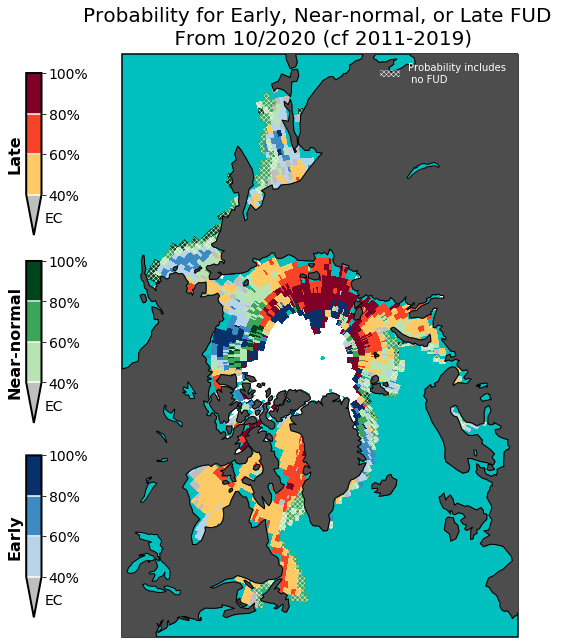

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
import matplotlib as mpl


###############################################################################
################## User-defined variables #####################################
###############################################################################

event = 'fud'
tc = 0.5 # threshold SIC for the event (needed to apply observation mask)

# initialization month
im = 10
im_id = "%02d" % im


# Climatology years (for computing forecast anomalies and event probabilities; 
# also just for creating filenames)
clim_yr_s = 2011
clim_yr_f = 2019

# Forecast year (also just for creating filenames)
fcst_yr = 2020

# the directories where the data are located and where the produced figure will be saved
dir_out = './Data/'

# path+filename of NCGR-calibrated forecast 
ncgr_netcdf = dir_out+event+'_fcst_ncgr_'+str(fcst_yr)+'_im'+im_id+'.nc'

# load observed SIC for day prior to the initialization date 
# this was obtained from https://nsidc.org/data/g10016 and interpolated onto the model grid.
# this is used to define the pre-occurrence of the event in the case that the forecast initialization
# does not accurately capture the event (e.g. due to discrepancies from assimilation)
sic_obs = Dataset(dir_out+'seaice_conc_daily_icdr_nh_f18_20200930_v01r00_rg.nc').variables['seaice_conc_cdr'][:][0]

###########################
ncgr_fcst_file = Dataset(ncgr_netcdf)
# forecast probabilities for early, normal, late event
ncgr_p_en = ncgr_fcst_file['prob_EN'][:][0]
ncgr_p_nn = ncgr_fcst_file['prob_NN'][:][0]
ncgr_p_ln = ncgr_fcst_file['prob_LN'][:][0]

# climatological terciles
clim_terc_low = ncgr_fcst_file['clim_1_3'][:][0]
clim_terc_up = ncgr_fcst_file['clim_2_3'][:][0]

# forecst probabilities for pre/non occurrence of the event
fcst_pre = ncgr_fcst_file['prob_pre'][:][0]
fcst_non = ncgr_fcst_file['prob_non'][:][0]

# set masked values to nan
fill_value = ncgr_fcst_file['prob_EN']._FillValue
ncgr_p_en[ncgr_p_en==fill_value] = np.nan
ncgr_p_nn[ncgr_p_nn==fill_value] = np.nan
ncgr_p_ln[ncgr_p_ln==fill_value] = np.nan

# load spatial variables and make 2d grid
lat = ncgr_fcst_file['latitude'][:]
lon = ncgr_fcst_file['longitude'][:]
LON, LAT = np.meshgrid(lon,lat)

# prep arrays to be filled with most likely category probability
ncgr_p_en_new = np.zeros(ncgr_p_en.shape)
ncgr_p_nn_new = np.zeros(ncgr_p_nn.shape)
ncgr_p_ln_new = np.zeros(ncgr_p_ln.shape)

# if category is most likely, set to the probability for that category (else it will be zero)
ncgr_p_en_new[ncgr_p_en==np.nanmax(np.array([ncgr_p_en,ncgr_p_nn,ncgr_p_ln]),axis=0)] = ncgr_p_en[ncgr_p_en==np.nanmax(np.array([ncgr_p_en,ncgr_p_nn,ncgr_p_ln]),axis=0)]
ncgr_p_nn_new[ncgr_p_nn==np.nanmax(np.array([ncgr_p_en,ncgr_p_nn,ncgr_p_ln]),axis=0)] = ncgr_p_nn[ncgr_p_nn==np.nanmax(np.array([ncgr_p_en,ncgr_p_nn,ncgr_p_ln]),axis=0)]
ncgr_p_ln_new[ncgr_p_ln==np.nanmax(np.array([ncgr_p_en,ncgr_p_nn,ncgr_p_ln]),axis=0)] = ncgr_p_ln[ncgr_p_ln==np.nanmax(np.array([ncgr_p_en,ncgr_p_nn,ncgr_p_ln]),axis=0)]

# mask for when the climatological 2/3 tercile is equal to the last day of the forecast or season.
clim_ut_mask = np.zeros(ncgr_p_nn_new.shape)
clim_ut_mask[(clim_terc_up==b)&(ncgr_p_nn_new>0.0)] = 1.0

# mask for white color in areas where the IFD (FUD) does not (has already) occur(red) at the end (start) 
# of the forecast
ice_mask = np.zeros(ncgr_p_nn_new.shape)
if event=='ifd':
    ice_mask[(fcst_non==1.0)|(sic_obs<tc)] = 1.0
if event=='fud':
    ice_mask[(fcst_pre==1.0)|(sic_obs>tc)] = 1.0

########### Plotting  #####################
# useful function for the colorbar
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    # cuts off the ends of cmap colors at minval and maxval
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
    cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# function for setting up Cartopy map
def set_up_subplot(fig,subplot=111):
    crs_np = ccrs.NorthPolarStereo(central_longitude=-45)
    ax = fig.add_subplot(subplot,projection=crs_np)
    
    xll, yll = crs_np.transform_point(279.26,33.92, ccrs.Geodetic())
    xur, yur = crs_np.transform_point(102.34,31.37, ccrs.Geodetic())
    
    ax.set_extent([xll,xur,yll,yur],crs=crs_np)

    ax.add_feature(cfeature.OCEAN,facecolor='c', zorder=1)
    ax.add_feature(cfeature.LAND,facecolor='0.3', zorder=3)
    ax.add_feature(cfeature.LAKES,facecolor='c',linestyle='-', edgecolor='k',zorder=3)
    ax.coastlines(resolution='110m',linewidth=1,color='k',zorder=3)       
    return ax

# levels for each colorbar
clevs = [0.4, 0.6, 0.8, 1.0]
clevs_lab = ['40','60','80','100']
clevs_lab = [n+'%' for n in clevs_lab]
clevs_ticks = np.array(clevs)

# colormaps for each category (note the color for early and late categories depends on the event)
if event=='fud':
    cmap_ln = cm.YlOrRd
    cmap_nn = cm.Greens
    cmap_en = cm.Blues
if event=='ifd':
    cmap_en = cm.YlOrRd
    cmap_nn = cm.Greens
    cmap_ln = cm.Blues

cmap_en = truncate_colormap(cmap_en,0.3,1.0)
cmap_nn = truncate_colormap(cmap_nn,0.3,1.0)
cmap_ln = truncate_colormap(cmap_ln,0.3,1.0)

cmap_en.set_under('0.75')
cmap_nn.set_under('0.75')
cmap_ln.set_under('0.75')

cmap_en.set_over(cm.YlOrRd(256))
cmap_nn.set_over(cm.Greens(256))
cmap_ln.set_over(cm.Blues(256))

norm_en = mpl.colors.BoundaryNorm(clevs, cmap_en.N)
norm_nn = mpl.colors.BoundaryNorm(clevs, cmap_nn.N)
norm_ln = mpl.colors.BoundaryNorm(clevs, cmap_ln.N)

#############################################################

fig = plt.figure(num=1,figsize=(8.5,9))
plt.clf()

ax = set_up_subplot(fig)

datain_masked = np.ma.array(ice_mask, mask=ice_mask==0.0)

masked_array1 = np.ma.array(ncgr_p_en_new, mask=ncgr_p_en_new==0.0)
masked_array2 = np.ma.array(ncgr_p_nn_new, mask=ncgr_p_nn_new==0.0)
masked_array3 = np.ma.array(ncgr_p_ln_new, mask=ncgr_p_ln_new==0.0)


ax.pcolormesh(LON,LAT,datain_masked, cmap=cm.Greys,
              rasterized=True,transform=ccrs.PlateCarree(), zorder=2) 

im1 = ax.pcolormesh(LON,LAT,masked_array1,vmin=0.4,vmax=1.0,
              cmap=cmap_en,norm=norm_en,rasterized=True,transform=ccrs.PlateCarree(), zorder=2) 

im2 = ax.pcolormesh(LON,LAT,masked_array2,vmin=0.4,vmax=1.0,
              cmap=cmap_nn,norm=norm_nn,rasterized=True,transform=ccrs.PlateCarree(), zorder=2)

im3 = ax.pcolormesh(LON,LAT,masked_array3,vmin=0.4,vmax=1.0,
              cmap=cmap_ln,norm=norm_ln,rasterized=True,transform=ccrs.PlateCarree(), zorder=2)

    
########### hatching for when the upper tercile for climatology includes the last day ############
label = 'Probability includes \n no '+event.upper()
masked_array4 = np.ma.array(clim_ut_mask, mask=clim_ut_mask==0.0)

plt.rcParams['hatch.color'] = 'white'
plt.rcParams['hatch.linewidth'] = 0.5
cs1 = ax.pcolor(LON,LAT,masked_array4, hatch='xxxxx', alpha=0.,
              rasterized=True,transform=ccrs.PlateCarree(), zorder=2, label=label)

cs2 = mpl.patches.Patch(alpha=0.0, hatch=cs1._hatch, label=label)
l = ax.legend(handles=[cs2], loc='upper right', frameon=False)
for text in l.get_texts():
    text.set_color('w')

######### colorbars
cbar_ax1 = fig.add_axes([0.035, 0.04, 0.025, 0.25])
cb1 = fig.colorbar(im1,cax=cbar_ax1,orientation='vertical',format='%d', ticks=clevs_ticks,
             spacing='uniform', drawedges=True, extend='min', boundaries=[0]+clevs, extendfrac='auto')
cbar_ax1.set_yticklabels(clevs_lab,fontsize=10)

cbar_ax2 = fig.add_axes([0.035, 0.34, 0.025, 0.25])
cb2 = fig.colorbar(im2,cax=cbar_ax2,orientation='vertical',format='%d', ticks=clevs_ticks,
             spacing='uniform',drawedges=True, extend='min', boundaries=[0]+clevs, extendfrac='auto')
cbar_ax2.set_yticklabels(clevs_lab,fontsize=10)

cbar_ax3 = fig.add_axes([0.035, 0.63, 0.025, 0.25])
cb3 = fig.colorbar(im3,cax=cbar_ax3,orientation='vertical',format='%d', ticks=clevs_ticks,
             spacing='uniform',drawedges=True, extend='min', boundaries=[0]+clevs,  extendfrac='auto')

cbar_ax1.set_yticklabels(clevs_lab,fontsize=14)
cbar_ax2.set_yticklabels(clevs_lab,fontsize=14)
cbar_ax3.set_yticklabels(clevs_lab,fontsize=14)

cbar_ax1.set_ylabel('Early', fontsize=16,fontweight='semibold')
cbar_ax2.set_ylabel('Near-normal', fontsize=16,fontweight='semibold')
cbar_ax3.set_ylabel('Late', fontsize=16,fontweight='semibold')

cbar_ax1.yaxis.set_label_position('left')
cbar_ax2.yaxis.set_label_position('left')
cbar_ax3.yaxis.set_label_position('left')


cb1.outline.set_linewidth(2)
cb1.outline.set_edgecolor('k')
cb1.dividers.set_color('w')
cb1.dividers.set_linewidth(1.5)

cb2.outline.set_linewidth(2)
cb2.outline.set_edgecolor('k')
cb2.dividers.set_color('w')
cb2.dividers.set_linewidth(1.5)

cb3.outline.set_linewidth(2)
cb3.outline.set_edgecolor('k')
cb3.dividers.set_color('w')
cb3.dividers.set_linewidth(1.5)

fig.text(0.065,0.06,'EC',fontsize=14)
fig.text(0.065,0.36,'EC',fontsize=14)
fig.text(0.065,0.65,'EC',fontsize=14)

ax.outline_patch.set_linewidth(1.5)


fig.subplots_adjust(left=0.05, right=0.98, top=0.91, bottom=0.01)

ax.set_title('Probability for Early, Near-normal, or Late '+event.upper()+' \n From '+im_id+'/'+str(fcst_yr)+' (cf '+str(clim_yr_s)+'-'+str(clim_yr_f)+')',
        fontsize=20,pad=10.)

#plt.savefig(dir_out+'/'+event.upper()+'_im'+str(im)+'_3category.png',dpi=700)

A couple things about the plot:
* The white area in the central Arctic is where the forecast is for a 100% chance of having already occurred at the time of initialization. If the plotting code above were applied to an ice-free date forecast, a white region would also exist in the central Arctic corresponding to where ice retreat is forecasted to not occur with 100% probability.

* The cyan area represents open ocean where no freeze-up has occured over the climatological record (i.e. the lower and upper terciles for the climatology are both equal to the date `a`.)

* When the climatological upper tercile is equal to the last day of the season, by definition the "near-normal" category includes this date in its limits. To highlight these locations on the map, I've used hatching to indicate where the upper tercile includes the last day of the season.